In [275]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


import math

import arviz as az
from scipy.stats import norm
from scipy import integrate
import hdbscan
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from astropy.coordinates import SkyCoord
import astropy.units as u
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

In [276]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=10)            # legend fontsize

%matplotlib inline

In [277]:
FILENAME = "gaiaedr3_180_NGC752.csv"
datafile = pd.read_csv(FILENAME, delimiter=",") 

In [278]:
FILENAME[0:-4]

'gaiaedr3_180_NGC752'

In [279]:
datafile.dropna(subset=['pmra', 'pmdec', 'parallax']).reset_index()
datafile['e_Gmag'] = abs(-2.5*datafile['phot_g_mean_flux_error']/math.log(10)/datafile['phot_g_mean_flux'])
datafile['e_BPmag'] = abs(-2.5*datafile['phot_bp_mean_flux_error']/math.log(10)/datafile['phot_bp_mean_flux'])
datafile['e_RPmag'] = abs(-2.5*datafile['phot_rp_mean_flux_error']/math.log(10)/datafile['phot_rp_mean_flux'])
datafile['bp_rp'] = datafile['phot_bp_mean_mag'] - datafile['phot_rp_mean_mag']
data = datafile[(datafile['parallax'] > 0.) & (datafile['e_Gmag'] < 0.005)].reset_index(drop=True)

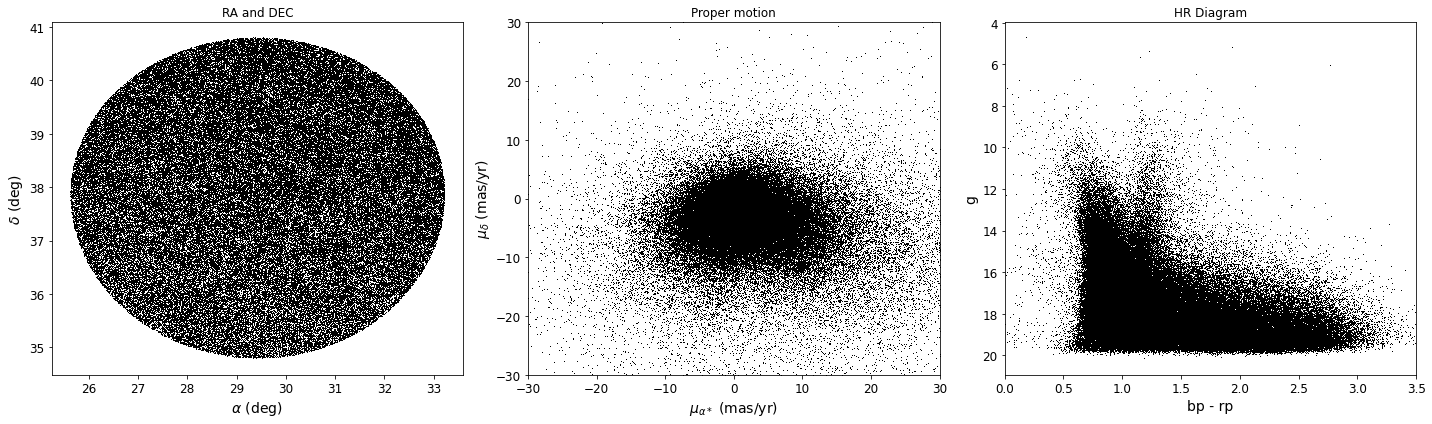

In [280]:
fig,ax = plt.subplots(1,3,figsize=(20, 6))

ax[0].plot(data['ra'], data['dec'], 'k,')
ax[0].set_xlabel(r'$\alpha$ (deg)')
ax[0].set_ylabel(r'$\delta$ (deg)')
ax[0].set_title('RA and DEC')

ax[1].plot(data['pmra'], data['pmdec'], 'k,')
ax[1].set_xlabel(r'$\mu_{\alpha*}$ (mas/yr)')
ax[1].set_ylabel(r'$\mu_{\delta}$ (mas/yr)')
ax[1].set_xlim(-30,30)
ax[1].set_ylim(-30,30)
ax[1].set_title('Proper motion')

ax[2].plot(data['bp_rp'], data['phot_g_mean_mag'], 'k,')
ax[2].invert_yaxis()
ax[2].set_xlim(0.,3.5)
ax[2].set_xlabel('bp - rp')
ax[2].set_ylabel('g')
ax[2].set_title('HR Diagram')
plt.tight_layout()
plt.savefig('givendata_'+FILENAME[0:-4]+'.jpeg')
plt.show()

In [281]:
df = data[["pmra", "pmdec", "parallax"]]
df = df.to_numpy().astype("float32", copy = False)

In [282]:
stscaler_df = StandardScaler().fit(df)
df_ = stscaler_df.transform(df)

In [283]:
clus_size = 2 * df_.shape[1]

In [284]:
clusterer = hdbscan.HDBSCAN(clus_size)
cluster_labels = clusterer.fit_predict(df_)

data['hdbscan'] = cluster_labels

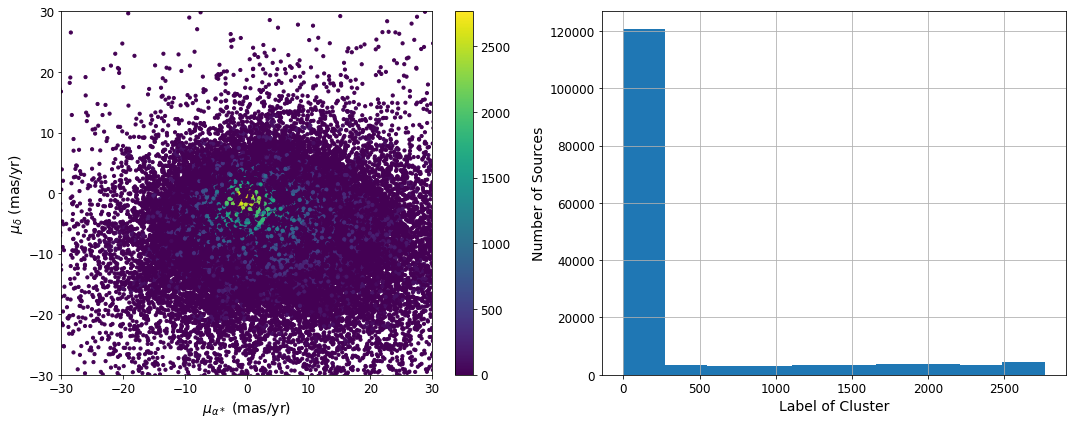

In [285]:
fig, ax = plt.subplots(1,2,figsize=(15,6))
gr = ax[0].scatter(data['pmra'], data['pmdec'], s=10, c=cluster_labels, edgecolor=None)

#ax[0].set_colorbar(gr, ax=ax[0])
ax[0].invert_yaxis()
plt.colorbar(gr,ax=ax[0])
ax[0].set_xlim(-30,30)
ax[0].set_ylim(-30,30)
ax[0].set_xlabel(r'$\mu_{\alpha*}$ (mas/yr)')
ax[0].set_ylabel(r'$\mu_{\delta}$ (mas/yr)')

ax[1].hist(data['hdbscan'])
ax[1].set_xlabel('Label of Cluster')
ax[1].set_ylabel('Number of Sources')
ax[1].grid()
plt.savefig('HDBSCAN_'+FILENAME[0:-4]+'.jpeg')
plt.tight_layout()
plt.show()

In [286]:
result_hdbscan = data[data['hdbscan'] >= 0].reset_index(drop=True)
c = result_hdbscan['hdbscan'].value_counts()
n_max = c.index[np.argmax(c)]
result = data[data['hdbscan'] == n_max]

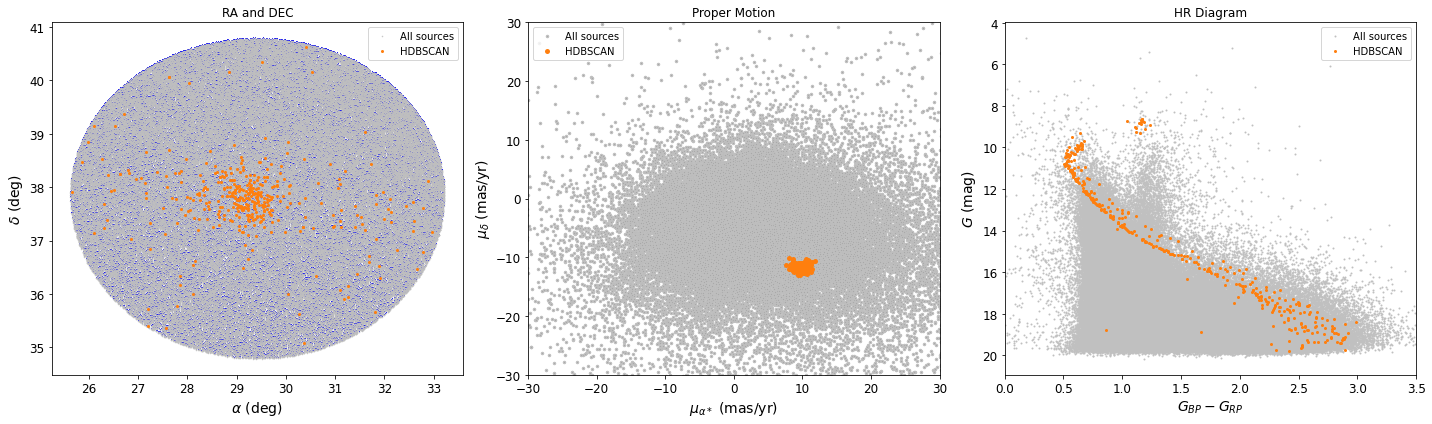

In [287]:
fig,ax = plt.subplots(1,3,figsize=(20, 6))

ax[0].plot(data['ra'], data['dec'], 'b,')
ax[0].plot(data['ra'], data['dec'], '.', mec='silver', mfc='darkgray', markersize=1., label="All sources")
ax[0].plot(result['ra'], result['dec'], 'o', mfc='tab:orange', markersize=2., label="HDBSCAN")
ax[0].set_xlabel(r'$\alpha$ (deg)')
ax[0].set_ylabel(r'$\delta$ (deg)')
ax[0].set_title('RA and DEC')
ax[0].legend()

ax[1].plot(data['pmra'], data['pmdec'], '.', mec='silver', mfc='darkgray', markersize=5., label="All sources")
ax[1].plot(result['pmra'], result['pmdec'], 'o', mfc='tab:orange', mec='None', markersize=5., label="HDBSCAN")
ax[1].set_xlabel(r'$\mu_{\alpha*}$ (mas/yr)')
ax[1].set_ylabel(r'$\mu_{\delta}$ (mas/yr)')
ax[1].set_xlim(-30,30)
ax[1].set_ylim(-30,30)
ax[1].set_title('Proper Motion')
ax[1].legend()

ax[2].plot(data['bp_rp'], data['phot_g_mean_mag'], '.', mec='silver', mfc='darkgray', markersize=2., label="All sources")
ax[2].plot(result['bp_rp'], result['phot_g_mean_mag'], 'o', color='tab:orange', markersize=2., label=r"HDBSCAN")
ax[2].invert_yaxis()
ax[2].set_xlim(0.,3.5)
ax[2].set_xlabel(r'$G_{BP}-G_{RP}$')
ax[2].set_ylabel(r'$G$ (mag)')
ax[2].legend()
ax[2].set_title('HR Diagram')
plt.tight_layout()
plt.savefig('max_num_cluster_'+FILENAME[0:-4]+'.jpeg')
plt.show()

In [288]:
ra_c    = np.mean(result.ra)
dec_c   = np.mean(result.dec)
pmra_c  = np.mean(result.pmra)
pmdec_c = np.mean(result.pmdec)
parallax_mean = np.mean(result.parallax)
parallax_std = np.std(result.parallax)

In [289]:
print('ra_c    = ',np.mean(result.ra))
print('dec_c   = ',np.mean(result.dec))
print('pmra_c  = ',np.mean(result.pmra))
print('pmdec_c = ',np.mean(result.pmdec))
print('parallax_mean = ',np.mean(result.parallax))
print('parallax_std = ',np.std(result.parallax))

ra_c    =  29.24811484101642
dec_c   =  37.74211493998658
pmra_c  =  9.782790437718138
pmdec_c =  -11.784769357220727
parallax_mean =  2.2387086434097183
parallax_std =  0.11160697294505052


In [290]:
result

,source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,pm,pmra,pmra_error,...,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_mag,dr2_radial_velocity,dr2_radial_velocity_error,e_Gmag,e_BPmag,e_RPmag,bp_rp,hdbscan
1909,318223202227962624,27.567768,0.020226,35.358811,0.015459,1.953406,0.018973,14.671955,10.506126,0.025930,...,29994.006218,26.010920,13.555309,NaN,NaN,0.000259,0.001531,0.000942,1.311299,268
2004,318232853018089472,27.202517,0.226145,35.396360,0.205579,2.112153,0.275491,16.120638,10.750215,0.281643,...,837.378233,13.373943,17.440592,NaN,NaN,0.002683,0.136288,0.017341,2.552444,268
2998,318269961536387328,27.795180,0.224002,35.780506,0.219248,2.044952,0.274284,15.193239,10.322385,0.324488,...,638.378015,16.325256,17.735200,NaN,NaN,0.003243,0.124420,0.027766,2.485196,268
3523,318292089207130752,27.198466,0.113398,35.723078,0.114192,2.056820,0.138073,15.080875,10.844782,0.145835,...,1396.187779,9.520344,16.885536,NaN,NaN,0.001875,0.072315,0.007403,2.590354,268
7723,344092885468413696,28.026777,0.325904,39.943058,0.364699,1.964481,0.379610,15.094495,8.891794,0.482864,...,551.489665,8.421601,17.894053,NaN,NaN,0.004848,0.110248,0.016580,2.886281,268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150269,331319309132002048,32.775380,0.341085,36.789041,0.300278,2.213036,0.365988,14.425470,8.077764,0.449493,...,437.405365,11.874529,18.145685,NaN,NaN,0.004701,0.136227,0.029475,2.668831,268
150955,331377926845710848,32.957705,0.293492,37.164950,0.310720,2.472307,0.352328,14.736646,9.341748,0.379010,...,430.364323,9.729965,18.163305,NaN,NaN,0.004476,0.125624,0.024547,2.858650,268
151300,331387551869347840,32.580048,0.063802,37.177659,0.066849,2.289026,0.076279,15.050242,8.964860,0.086659,...,2896.214833,8.934103,16.093319,NaN,NaN,0.001076,0.016687,0.003349,2.183921,268
151702,331398856223257472,32.601528,0.117422,37.369684,0.112537,1.965220,0.132099,15.037616,8.570863,0.149609,...,1622.950449,11.726293,16.722132,NaN,NaN,0.001687,0.046496,0.007845,2.548473,268


## Distance Calculaton

In [291]:
def likelihood(p, r, sigma):
    return norm.pdf(p,1000/r,sigma)

#Uniform Prior
def Prior_uniform(r, rlim):
    return np.piecewise(r, [r < 0, (r > 0)*(r<rlim), r > rlim], [0, 1/rlim, 0])

def Posterior(r, p, sigma_p, rmin, rlim,prior='Uniform'):
    if prior == 'Uniform':
        return Prior_uniform(r, rlim)*likelihood(p, r, sigma_p)
    
   

In [292]:
resolution = 50000
rlim = max(1000/result.parallax)+500
rmin = min(1000/result.parallax)-500
r = np.linspace(rmin, rlim, resolution)


In [293]:
Likelihood = likelihood(parallax_mean, r, parallax_std)
Area = integrate.simps(Likelihood, r)
Likelihood /= Area    #Normalize the likelihood

Prior = Prior_uniform(r, rlim)

posterior = Posterior(r, parallax_mean, parallax_std, rmin, rlim, prior='Uniform')
Area = integrate.simps(posterior, r)
posterior /= Area    #Normalize the posterior



In [294]:
result['distance']=1000/result.parallax

/home/vysakh/.local/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


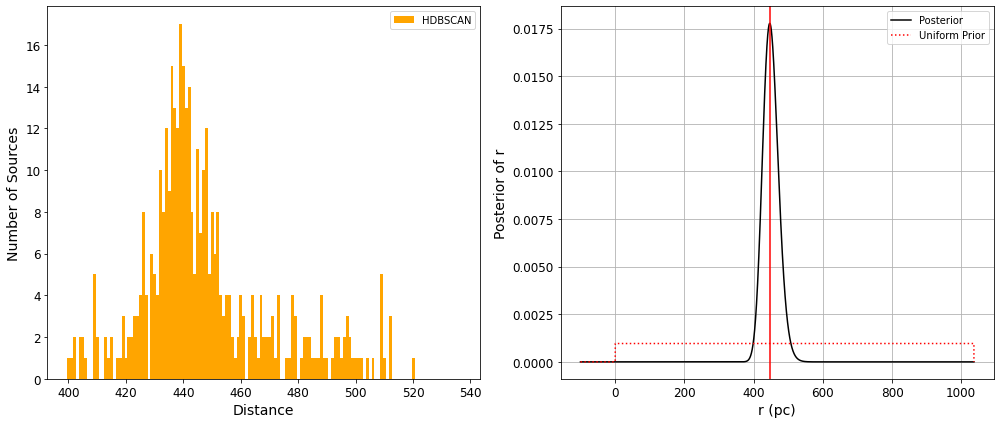

In [295]:
bins_dist = np.arange(result.distance.min(), result.distance.max(), 1)
fig,ax=plt.subplots(1,2,figsize=(14, 6))
ax[0].hist(result.distance,bins=bins_dist, color='orange', label="HDBSCAN")
ax[0].set_xlabel(r'Distance')
ax[0].set_ylabel('Number of Sources')
ax[0].legend()


ax[1].plot(r, posterior,'k-' ,label='Posterior')
ax[1].plot(r, Prior,'r:' ,label='Uniform Prior')
ax[1].set_xlabel('r (pc)')
ax[1].set_ylabel('Posterior of r')
ax[1].axvline(r[np.argmax(posterior)],color='red')
ax[1].legend()
ax[1].grid()
plt.tight_layout()
plt.savefig('Distance'+FILENAME[0:-4]+'.jpeg')
plt.show()

In [296]:
print('Distance:',r[np.argmax(posterior)])
distance=r[np.argmax(posterior)]
np.std(result.distance)

Distance: 446.68451659057894


23.284121097210456

## Hands-On: Open Cluster Membership Determination using GMM

In [297]:
allsource = data[[
    'ra', 
    'ra_error', 
    'dec', 
    'dec_error', 
    'parallax',
    'parallax_error', 
    'pmra', 
    'pmra_error', 
    'pmdec',
    'pmdec_error', 
    'phot_g_mean_mag',
    'bp_rp'
]]

In [298]:
HDBSCAN_MEAN_PMRA     = pmra_c
HDBSCAN_MEAN_PMDEC    = pmdec_c
HDBSCAN_MEAN_PARALLAX = parallax_mean

PMRA_RANGE     = 3.
PMDEC_RANGE    = 3.
PARALLAX_RANGE = 2.25

In [299]:
samplesource = allsource[
    (allsource['pmra'] >= HDBSCAN_MEAN_PMRA-(PMRA_RANGE/2.)) & (allsource['pmra'] <= HDBSCAN_MEAN_PMRA+(PMRA_RANGE/2.)) & 
    (allsource['pmdec'] >= HDBSCAN_MEAN_PMDEC-(PMDEC_RANGE/2.)) & (allsource['pmdec'] <= HDBSCAN_MEAN_PMDEC+(PMDEC_RANGE/2.)) &
    (allsource['parallax'] >= HDBSCAN_MEAN_PARALLAX-(PARALLAX_RANGE/2.)) & (allsource['parallax'] <= HDBSCAN_MEAN_PARALLAX+(PARALLAX_RANGE/2.))
].reset_index(drop=True)

df = samplesource[["pmra", "pmdec", "parallax"]]
df = df.to_numpy().astype("float32", copy = False)

stscaler_df = StandardScaler().fit(df)
df_ = stscaler_df.transform(df)

norm_pmra = df_[:,0]
norm_pmde = df_[:,1]
norm_para = df_[:,2]

sample_data_dict = {
    'norm_pmra' : norm_pmra,
    'norm_pmde' : norm_pmde,
    'norm_para' : norm_para,
}

sample_data = pd.DataFrame(sample_data_dict)

In [300]:
gmm = GaussianMixture(n_components=2, max_iter=1000, covariance_type='full', random_state=None).fit(sample_data)

pred_data = gmm.predict_proba(sample_data)

samplesource['prob'] = pred_data[:,0]

In [301]:
member_ultra = samplesource[samplesource['prob'] >= .8].reset_index(drop=True)
member_high  = samplesource[samplesource['prob'] >= .6].reset_index(drop=True)
member_moder = samplesource[(samplesource['prob'] > .2) & (samplesource['prob'] < .6)].reset_index(drop=True)
member_low   = samplesource[samplesource['prob'] <= .2].reset_index(drop=True)

member_incl = member_moder[(member_moder['parallax'] >= member_ultra['parallax'].min()) & 
                           (member_moder['parallax'] <= member_ultra['parallax'].max())].reset_index(drop=True)



In [302]:
member_all = pd.concat([member_high, member_incl]).sort_values(by=['prob'], ascending=False).reset_index(drop=True)

In [303]:
len(member_all)

461

In [304]:
member_dist=1/member_all.parallax

In [305]:
mean_pmra_val = np.mean(member_all['pmra'])
mean_pmra_std = np.std(member_all['pmra'])
mean_pmde_val = np.mean(member_all['pmdec'])
mean_pmde_std = np.std(member_all['pmdec'])
mean_dist_val = np.mean(member_dist )
mean_dist_std = np.std(member_dist )


bins = np.linspace(0., 1., 10)

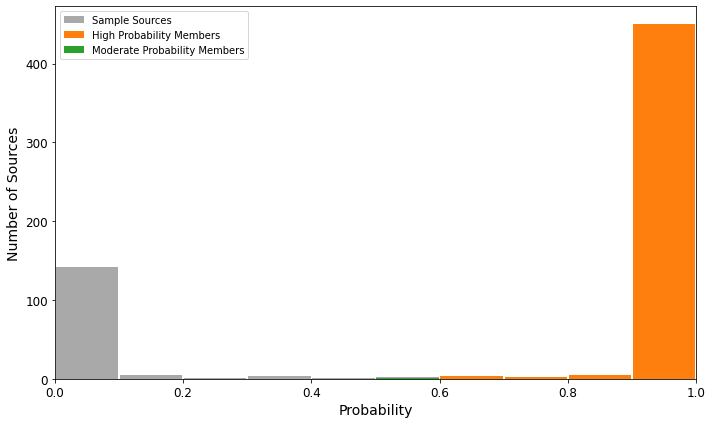

In [306]:
plt.figure(figsize=(10, 6))
plt.hist(samplesource['prob'], bins=[0., .1, .2, .3, .4, .5, .6, .7, .8, .9, 1.], color='darkgray', rwidth=.975, label="Sample Sources")
plt.hist(member_high['prob'], bins=[.6, .7, .8, .9, 1.], color='tab:orange', rwidth=.975, label="High Probability Members")
plt.hist(member_incl['prob'], bins=[.2, .3, .4, .5, .6], color='tab:green', rwidth=.975, label="Moderate Probability Members")

plt.xlabel("Probability")
plt.ylabel("Number of Sources")

plt.xlim([0., 1.])

plt.xticks()
plt.yticks()

plt.legend()
plt.tight_layout()
plt.savefig('Prob_hist_'+FILENAME[0:-4]+'.jpeg')

plt.show()

In [307]:
bins_samp = np.arange(samplesource['parallax'].min(), samplesource['parallax'].max(), .05)
bins_high = np.arange(member_high['parallax'].min(), member_high['parallax'].max(), .05)
bins_mode = np.arange(member_incl['parallax'].min(), member_incl['parallax'].max(), .05)

In [308]:
coor_all  = SkyCoord(ra=samplesource.ra, dec=samplesource.dec, frame='icrs', unit=(u.deg, u.deg))
coor_high = SkyCoord(ra=member_high.ra, dec=member_high.dec, frame='icrs', unit=(u.deg, u.deg))
coor_mid  = SkyCoord(ra=member_incl.ra, dec=member_incl.dec, frame='icrs', unit=(u.deg, u.deg))

In [309]:
ra_all  = coor_all.ra.wrap_at(180 * u.deg).degree
de_all  = coor_all.dec.degree

ra_high = coor_high.ra.wrap_at(180 * u.deg).degree
de_high = coor_high.dec.degree

ra_mid  = coor_mid.ra.wrap_at(180 * u.deg).degree
de_mid  = coor_mid.dec.degree

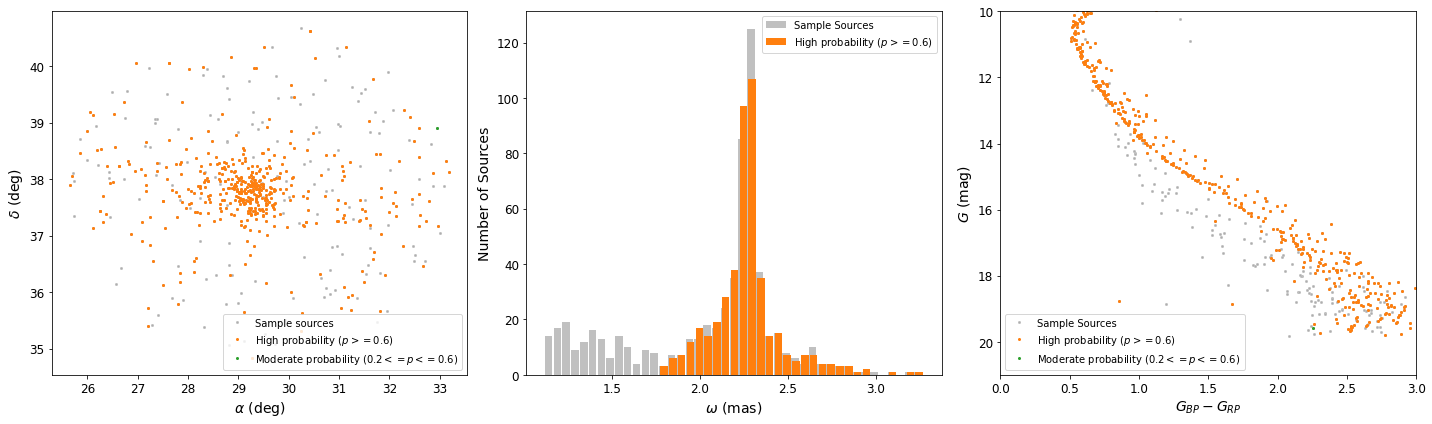

In [310]:
fig,ax = plt.subplots(1,3,figsize=(20, 6))
ax[0].plot(ra_all, de_all, 'o', mec='silver', mfc='darkgray', markersize=2., label="Sample sources")
ax[0].plot(ra_high, de_high, 'o', mfc='tab:orange', markersize=2., label=r"High probability ($p >= 0.6$)")
ax[0].plot(ra_mid, de_mid, 'o', mfc='tab:green', markersize=2., label=r"Moderate probability ($0.2 <= p <= 0.6$)")
ax[0].set_xlabel(r'$\alpha$ (deg)')
ax[0].set_ylabel(r'$\delta$ (deg)')
ax[0].legend()

ax[1].hist(samplesource.parallax,bins=bins_samp, color='silver', rwidth=.85, label="Sample Sources")
ax[1].hist(member_high.parallax,bins=bins_high, color='tab:orange', rwidth=.85, label=r"High probability ($p >= 0.6$)")
ax[1].hist(member_incl.parallax,bins=bins_mode, color='tab:green', rwidth=.85, label=r"Moderate probability ($0.2 <= p <= 0.6$)")
ax[1].set_xlabel(r"$\omega$ (mas)")
ax[1].set_ylabel("Number of Sources")
#ax[1].set_xticks()
#ax[1].set_yticks()
ax[1].legend()

ax[2].plot(samplesource['bp_rp'], samplesource['phot_g_mean_mag'], 'o', mec='silver', mfc='darkgray', markersize=2., label="Sample Sources")
ax[2].plot(member_high['bp_rp'], member_high['phot_g_mean_mag'], 'o', color='tab:orange', markersize=2., label=r"High probability ($p >= 0.6$)")
ax[2].plot(member_incl['bp_rp'], member_incl['phot_g_mean_mag'], 'o', color='tab:green', markersize=2., label=r"Moderate probability ($0.2 <= p <= 0.6$)")
#plt.plot(data123.G_BPmag-data123.G_RPmag,data123.Gmag,'b.')
ax[2].set_xlabel(r"$G_{BP}-G_{RP}$")
ax[2].set_ylabel(r"$G$ (mag)")
ax[2].set_xlim([0., 3.])
ax[2].set_ylim([10, 21])
ax[2].invert_yaxis()
ax[2].legend()
plt.tight_layout()
plt.savefig('Cluster_members_'+FILENAME[0:-4]+'.jpeg')

plt.show()

# Isochrone Fitting

In [311]:
isochrone1=pd.read_csv('1.txt',sep='\s+')
isochrone1['bp_rp']=isochrone1.G_BPmag-isochrone1.G_RPmag
isochrone2=pd.read_csv('2.txt',sep='\s+')
isochrone2['bp_rp']=isochrone2.G_BPmag-isochrone2.G_RPmag
isochrone3=pd.read_csv('3.txt',sep='\s+')
isochrone3['bp_rp']=isochrone3.G_BPmag-isochrone3.G_RPmag
isochrone4=pd.read_csv('4.txt',sep='\s+')
isochrone4['bp_rp']=isochrone4.G_BPmag-isochrone4.G_RPmag
isochrone5=pd.read_csv('5.txt',sep='\s+')
isochrone5['bp_rp']=isochrone5.G_BPmag-isochrone5.G_RPmag


In [312]:
M=member_high['phot_g_mean_mag']-5*np.log10(distance/10)+.1
member_high['Abs_mag']=M

In [313]:
isochrone1_filt=isochrone1.loc[(isochrone1.Gmag>0)&(isochrone1.Gmag<22)&(isochrone1['bp_rp']<3.2)]
isochrone2_filt=isochrone2.loc[(isochrone2.Gmag>0)&(isochrone2.Gmag<22)&(isochrone2['bp_rp']<3.2)]
isochrone3_filt=isochrone3.loc[(isochrone3.Gmag>0)&(isochrone3.Gmag<22)&(isochrone3['bp_rp']<3.2)]
isochrone4_filt=isochrone4.loc[(isochrone4.Gmag>0)&(isochrone4.Gmag<22)&(isochrone4['bp_rp']<3.2)]
isochrone5_filt=isochrone5.loc[(isochrone5.Gmag>0)&(isochrone5.Gmag<22)&(isochrone5['bp_rp']<3.2)]

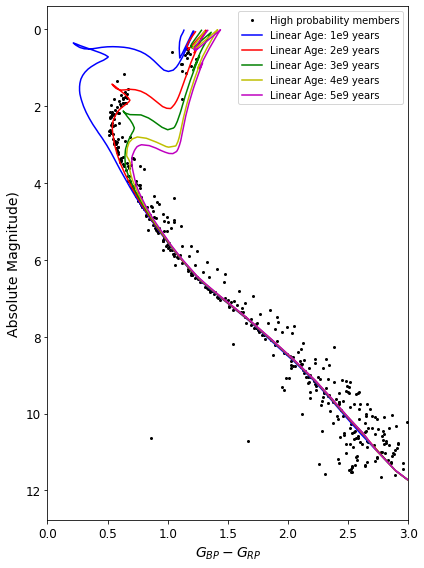

In [314]:
plt.figure(figsize=(6, 8))
plt.plot(member_high['bp_rp'], member_high['Abs_mag'], 'o', color='k', markersize=2., label=r"High probability members")

plt.plot(isochrone1_filt.bp_rp,isochrone1_filt.Gmag,'b-',alpha=1,label='Linear Age: 1e9 years')
plt.plot(isochrone2_filt.bp_rp,isochrone2_filt.Gmag,'r-',alpha=1,label='Linear Age: 2e9 years')
plt.plot(isochrone3_filt.bp_rp,isochrone3_filt.Gmag,'g-',alpha=1,label='Linear Age: 3e9 years')
plt.plot(isochrone4_filt.bp_rp,isochrone4_filt.Gmag,'y-',alpha=1,label='Linear Age: 4e9 years')
plt.plot(isochrone5_filt.bp_rp,isochrone5_filt.Gmag,'m-',alpha=1,label='Linear Age: 5e9 years')

plt.xlabel(r"$G_{BP}-G_{RP}$")
plt.ylabel(r"Absolute Magnitude)")

plt.xlim([0., 3.])

plt.gca().invert_yaxis()
plt.legend()
plt.tight_layout()
plt.savefig('Adjusted_Mag_iso'+FILENAME[0:-4]+'.jpeg')

plt.show()

In [315]:
from patsy import dmatrix
import statsmodels.formula.api as smf
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [316]:
#high_sorted=member_high.sort_values(by=['bp_rp'],ascending=True)
member_high=member_high.dropna()
X_train,X_test,y_train,y_test = train_test_split(member_high.bp_rp, member_high.Abs_mag, test_size=0.3,random_state=13343)


In [317]:
train_test=pd.DataFrame()

train_test['X_train']=X_train
train_test['X_test']=X_test
train_test['y_train']=y_train
train_test['y_test']=y_test

train_test=train_test.loc[(train_test.y_train>2) & (train_test.X_train>0.5)]
X_train,X_test,y_train,y_test=train_test.X_train,train_test.X_test,train_test.y_train,train_test.y_test

In [318]:
min(X_train)

0.5093529999999991

0.5810119972182063
0.9599923757919127


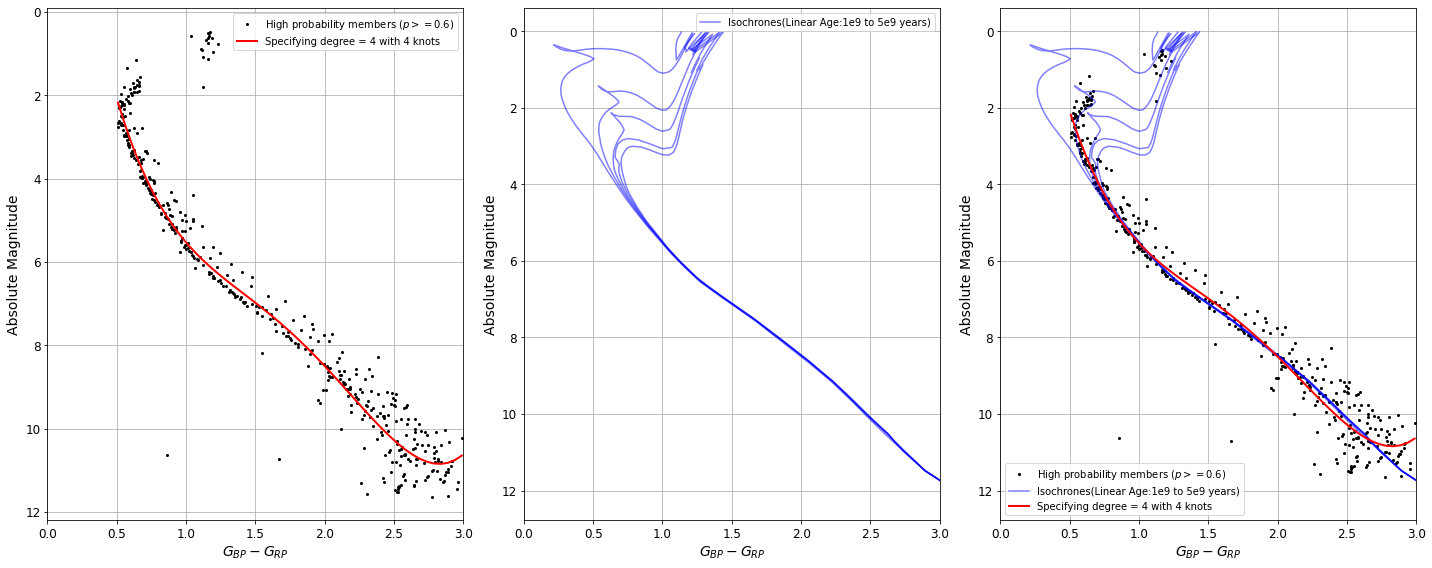

In [319]:



knots = 4
degree = 4 # try different knots and degree values

X_spline = dmatrix('bs(x,df = '+str(knots)+', degree = '+str(degree)+', include_intercept = False)', {'x': X_train.array},return_type = 'dataframe')
spline_sm = sm.GLM(y_train.array,X_spline,family=sm.families.Gaussian())
spline_fit=spline_sm.fit()
y_pred_train = spline_fit.predict(dmatrix('bs(test, df = '+str(knots)+', degree = '+str(degree)+', include_intercept = False)', {'test': X_train},return_type = 'dataframe'))
rmse_train = np.sqrt(mean_squared_error(y_train,y_pred_train))
print(rmse_train)   
print(r2_score(y_train,y_pred_train))

#y_pred = spline_fit.predict(dmatrix('bs(test, df = '+str(knots)+', degree = '+str(degree)+', include_intercept = False)', {'test': X_test},return_type = 'dataframe'))
#rmse_test = np.sqrt(mean_squared_error(y_test,y_pred))
#print(rmse_test)
#print(r2_score(y_test,y_pred))

range_pred = np.linspace(np.min(X_train),np.max(X_train),50)
prediction = spline_fit.predict(dmatrix('bs(xp, df = '+str(knots)+', degree = '+str(degree)+',include_intercept = False)', {'xp': range_pred},return_type = 'dataframe'))

fig,ax=plt.subplots(1,3,figsize=(20, 8))

ax[0].plot(member_high['bp_rp'], member_high['Abs_mag'], 'o', color='k', markersize=2., label=r"High probability members ($p >= 0.6$)")
ax[0].plot(range_pred, prediction, color='r',lw=2, label='Specifying degree = '+str(degree)+' with '+str(knots)+' knots')
ax[0].set_xlabel(r"$G_{BP}-G_{RP}$")
ax[0].set_ylabel(r"Absolute Magnitude")
ax[0].set_xlim([0., 3.])
ax[0].invert_yaxis()
ax[0].legend()
ax[0].grid()
                                
                                 
                                 
ax[1].plot(isochrone1_filt.bp_rp,isochrone1_filt.Gmag,'b-',alpha=0.5,label='Isochrones(Linear Age:1e9 to 5e9 years)')
ax[1].plot(isochrone2_filt.bp_rp,isochrone2_filt.Gmag,'b-',alpha=0.5)
ax[1].plot(isochrone3_filt.bp_rp,isochrone3_filt.Gmag,'b-',alpha=0.5)
ax[1].plot(isochrone4_filt.bp_rp,isochrone4_filt.Gmag,'b-',alpha=0.5)
ax[1].plot(isochrone5_filt.bp_rp,isochrone5_filt.Gmag,'b-',alpha=0.5)
ax[1].set_xlabel(r"$G_{BP}-G_{RP}$")
ax[1].set_ylabel(r"Absolute Magnitude")
ax[1].set_xlim([0., 3.])
ax[1].invert_yaxis()
ax[1].legend()
ax[1].grid()

                                 
                                 
ax[2].plot(member_high['bp_rp'], member_high['Abs_mag'], 'o', color='k', markersize=2., label=r"High probability members ($p >= 0.6$)")
ax[2].plot(isochrone1_filt.bp_rp,isochrone1_filt.Gmag,'b-',alpha=0.5,label='Isochrones(Linear Age:1e9 to 5e9 years)')
ax[2].plot(isochrone2_filt.bp_rp,isochrone2_filt.Gmag,'b-',alpha=0.5)
ax[2].plot(isochrone3_filt.bp_rp,isochrone3_filt.Gmag,'b-',alpha=0.5)
ax[2].plot(isochrone4_filt.bp_rp,isochrone4_filt.Gmag,'b-',alpha=0.5)
ax[2].plot(isochrone5_filt.bp_rp,isochrone5_filt.Gmag,'b-',alpha=0.5)
ax[2].plot(range_pred, prediction, color='r',lw=2, label='Specifying degree = '+str(degree)+' with '+str(knots)+' knots')
ax[2].set_xlabel(r"$G_{BP}-G_{RP}$")
ax[2].set_ylabel(r"Absolute Magnitude")
ax[2].set_xlim([0., 3.])
ax[2].invert_yaxis()
ax[2].legend(loc='best')
ax[2].grid()
plt.tight_layout()
plt.savefig('Final_iso_splines_'+FILENAME[0:-4]+'.jpeg')

plt.show()

In [320]:
train_test=train_test.sort_values(by='X_train')
rolling_mean=train_test.y_train.rolling(window=20,win_type='gaussian').mean(std=20)

#exp1 = high_sorted.Abs_mag.ewm(span=50, adjust=False).mean()

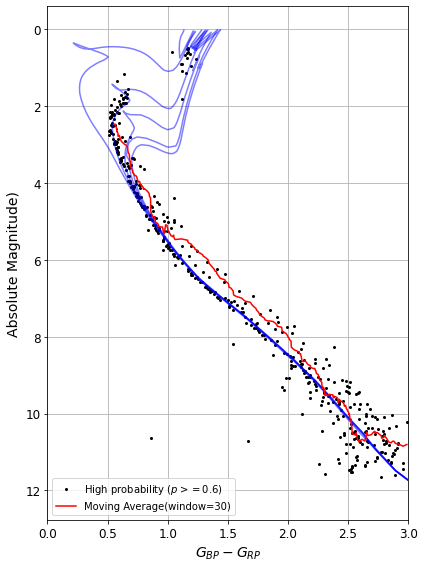

In [321]:
plt.figure(figsize=(6, 8))
#plt.plot(samplesource['bp_rp'], samplesource['phot_g_mean_mag'], 'o', mec='silver', mfc='darkgray', markersize=2., label="Sample Sources")
plt.plot(member_high['bp_rp'], member_high['Abs_mag'], 'o', color='k', markersize=2., label=r"High probability ($p >= 0.6$)")
#plt.plot(member_incl['bp_rp'], member_incl['phot_g_mean_mag'], 'o', color='tab:green', markersize=2., label=r"Moderate probability ($0.2 <= p <= 0.6$)")
plt.plot(isochrone1_filt.bp_rp,isochrone1_filt.Gmag,'b-',alpha=0.5)
plt.plot(isochrone2_filt.bp_rp,isochrone2_filt.Gmag,'b-',alpha=0.5)
plt.plot(isochrone3_filt.bp_rp,isochrone3_filt.Gmag,'b-',alpha=0.5)
plt.plot(isochrone4_filt.bp_rp,isochrone4_filt.Gmag,'b-',alpha=0.5)
plt.plot(isochrone5_filt.bp_rp,isochrone5_filt.Gmag,'b-',alpha=0.5)

plt.plot(train_test.X_train,rolling_mean,'r-',label='Moving Average(window=30)')
#plt.plot(high_sorted['bp_rp'],exp1,'r-')
plt.xlabel(r"$G_{BP}-G_{RP}$")
plt.ylabel(r"Absolute Magnitude)")
plt.grid()
plt.xlim([0., 3.])

plt.gca().invert_yaxis()
plt.legend()
plt.tight_layout()
plt.show()

# 